# Assignment 2: Clustering – Sessa Empirical Estimator (SEE)


## Overview
This notebook demonstrates:
- **Tasks 1–3 (already completed)**: Reading Sessa Empirical Estimator (SEE) background, converting R code, generating or loading a dataset.
- **Task 4**: Substituting **DBSCAN** as an alternative to the default K-Means in the SEE.
- **Task 5**: Comparing SEE results using **K-Means** vs. **DBSCAN**.

### References
1. [Rationale and Performances of a Data-Driven Method... (Pazzagli et al.)](#)
2. [A Newly Developed Method for Assessing Co-Exposure... (Barbieri et al.)](#)
3. [A Novel Approach for Pharmacological Substantiation... (Wang et al.)](#)
4. [AdhereR Package Documentation: med.events.ATC](https://search.r-project.org/CRAN/refmans/AdhereR/html/med.events.ATC.html)

---



In [12]:
# =============================================================================
# 0. IMPORT REQUIRED LIBRARIES
# =============================================================================

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# Set a style for seaborn plots
sns.set(style="whitegrid")

print("Libraries imported successfully.")


Libraries imported successfully.


## 1. Data Creation or Loading

Here, we generate a **synthetic dataset** called `synthetic_data` to mimic prescription records:

- Each patient (pnr) has multiple prescription fills on different dates (eksd).
- ATC (or med code) is set to "MYMED" for simplicity.

If you have a real dataset, load it instead (must contain at least columns: `['pnr', 'eksd', 'ATC']`).


In [13]:
# =============================================================================
# 1. CREATE SYNTHETIC DATASET
# =============================================================================

np.random.seed(42)

n_patients = 100
pnr_list = []
eksd_list = []
ATC_list = []

for p in range(1, n_patients + 1):
    # Each patient has 3 to 8 prescription fills
    fill_count = np.random.randint(3, 9)
    start_date = dt.date(2023, 1, 1)

    # Random intervals around 30 days, with some variability
    intervals = np.abs(np.random.normal(loc=30, scale=10, size=fill_count)).astype(int)
    
    current_date = start_date
    for i in range(fill_count):
        pnr_list.append(p)
        eksd_list.append(current_date)
        ATC_list.append("MYMED")  # Single medication code for demonstration
        current_date += dt.timedelta(days=int(intervals[i]))

# Build DataFrame
synthetic_data = pd.DataFrame({
    'pnr': pnr_list,
    'eksd': eksd_list,
    'ATC': ATC_list
})

synthetic_data['eksd'] = pd.to_datetime(synthetic_data['eksd'])
synthetic_data.sort_values(by=['pnr', 'eksd'], inplace=True)
synthetic_data.reset_index(drop=True, inplace=True)

print(f"synthetic_data shape: {synthetic_data.shape}")
synthetic_data.head()


synthetic_data shape: (543, 3)


,pnr,eksd,ATC
0,1,2023-01-01,MYMED
1,1,2023-01-19,MYMED
2,1,2023-02-21,MYMED
3,1,2023-03-25,MYMED
4,1,2023-05-04,MYMED


## 2. Helper Function: ECDF Cutoff

We'll define a function to compute the **empirical CDF cutoff** for `event_interval` and truncate extreme outliers above this percentile. This logic mirrors the original R code's approach of discarding the top X% of intervals.


In [14]:
# =============================================================================
# 2. HELPER FUNCTION: COMPUTE ECDF CUTOFF
# =============================================================================

def compute_ecdf_cutoff(df, column='event_interval', cutoff_percentile=80):
    """
    Computes a cutoff value for 'column' using an empirical CDF,
    discarding the top (100 - cutoff_percentile)% as extreme values.
    
    Returns 0 if the dataframe is empty or no intervals are found.
    """
    values = df[column].values
    if len(values) == 0:
        print(f"[Warning] No values in column '{column}'. Returning cutoff=0.")
        return 0
    
    intervals_sorted = np.sort(values)
    cdf_vals = np.arange(1, len(intervals_sorted) + 1) / float(len(intervals_sorted))
    cutoff_index = np.where(cdf_vals <= (cutoff_percentile / 100))[0]
    if len(cutoff_index) > 0:
        cutoff_val = intervals_sorted[cutoff_index[-1]]
    else:
        cutoff_val = intervals_sorted[-1]
    return cutoff_val

print("compute_ecdf_cutoff function defined.")


compute_ecdf_cutoff function defined.


## 3. Task 4: Sessa Empirical Estimator with **DBSCAN**

We adapt the logic from `SEE.R` to:

1. Filter by `medication_code` (defaults to "MYMED").  
2. Sort by pnr, date, then calculate refill intervals.  
3. Truncate via ECDF (e.g., 85th percentile).  
4. **DBSCAN**: Cluster the log of event intervals.  
5. Compute the **Silhouette Score** for valid clusters (excludes outliers).  


In [15]:
# =============================================================================
# 3. DBSCAN-BASED SEE
# =============================================================================

def sessa_empirical_estimator_dbscan(df, medication_code="MYMED", cutoff_percentile=85,
                                     eps=0.8, min_samples=5):
    """
    Sessa Empirical Estimator using DBSCAN for clustering.
    """
    # 1. Filter data for target medication
    data = df[df['ATC'] == medication_code].copy()
    data.sort_values(by=['pnr', 'eksd'], inplace=True)
    
    # 2. Compute refill intervals
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data.dropna(subset=['prev_eksd'], inplace=True)
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days.astype(float)
    
    # 3. Truncate extreme intervals via ECDF
    cutoff_val = compute_ecdf_cutoff(data, 'event_interval', cutoff_percentile)
    truncated_data = data[data['event_interval'] <= cutoff_val].copy()
    
    if truncated_data.empty:
        print("[Warning] After ECDF truncation, no data remains. Returning empty DataFrame.")
        return truncated_data
    
    # 4. Log-transform & standardize
    truncated_data['log_interval'] = np.log(truncated_data['event_interval'].values)
    X_scaled = StandardScaler().fit_transform(truncated_data[['log_interval']])
    
    # 5. Apply DBSCAN
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan_model.fit_predict(X_scaled)
    truncated_data['cluster_id'] = cluster_labels
    
    # 6. (Optional) Silhouette Score (excluding outliers = -1)
    unique_clusters = set(cluster_labels)
    if len(unique_clusters - {-1}) > 1:
        mask = truncated_data['cluster_id'] != -1
        sscore = silhouette_score(X_scaled[mask], truncated_data.loc[mask,'cluster_id'])
        print(f"DBSCAN Silhouette Score (excluding outliers): {sscore:.3f}")
    else:
        print("DBSCAN Silhouette Score: not applicable (0 or 1 valid clusters).")
    
    return truncated_data

# --- Usage ---
dbscan_results = sessa_empirical_estimator_dbscan(synthetic_data)
print("\nDBSCAN cluster distribution (includes outliers = -1):")
print(dbscan_results['cluster_id'].value_counts().sort_index())

dbscan_results.head()


DBSCAN Silhouette Score (excluding outliers): 0.750

DBSCAN cluster distribution (includes outliers = -1):
cluster_id
0    372
1      5
Name: count, dtype: int64


,pnr,eksd,ATC,prev_eksd,event_interval,log_interval,cluster_id
1,1,2023-01-19,MYMED,2023-01-01,18.0,2.890372,0
2,1,2023-02-21,MYMED,2023-01-19,33.0,3.496508,0
3,1,2023-03-25,MYMED,2023-02-21,32.0,3.465736,0
5,1,2023-05-28,MYMED,2023-05-04,24.0,3.178054,0
9,2,2023-04-05,MYMED,2023-03-31,5.0,1.609438,1


### 3.1 Visualizing DBSCAN Results

We'll create a quick boxplot to see how refill intervals are distributed per cluster, including any outliers (`cluster_id = -1`).


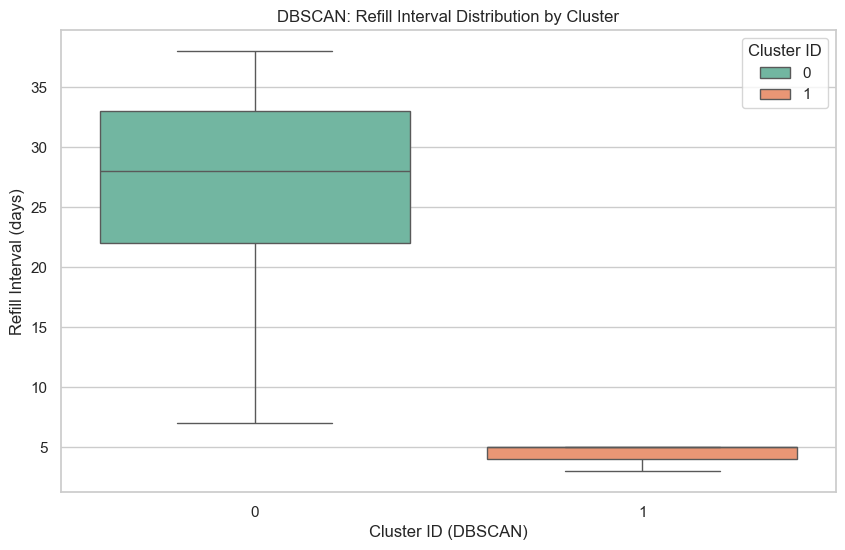

In [16]:
# =============================================================================
# 3.1 VISUALIZE DBSCAN CLUSTERS
# =============================================================================
if not dbscan_results.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=dbscan_results, 
        x='cluster_id', 
        y='event_interval',
        hue='cluster_id',  # ensures color distinction
        palette='Set2',
        dodge=False
    )
    plt.title("DBSCAN: Refill Interval Distribution by Cluster")
    plt.xlabel("Cluster ID (DBSCAN)")
    plt.ylabel("Refill Interval (days)")
    plt.legend(title='Cluster ID')
    plt.show()
else:
    print("[Info] dbscan_results is empty; no plot to show.")


## 4. Task 5: Compare K-Means vs. DBSCAN

Now we re-implement the **original** Sessa Empirical Estimator approach with **K-Means** and compare:

1. **Cluster counts**  
2. **Median refill intervals**  
3. **Outliers** (K-Means doesn’t isolate outliers the way DBSCAN does).  


In [17]:
# =============================================================================
# 4. K-MEANS-BASED SEE
# =============================================================================

def sessa_empirical_estimator_kmeans(df, medication_code="MYMED",
                                     cutoff_percentile=85, n_clusters=2):
    """
    Sessa Empirical Estimator using K-Means (default approach).
    """
    # 1. Filter & sort data
    data = df[df['ATC'] == medication_code].copy()
    data.sort_values(by=['pnr','eksd'], inplace=True)

    # 2. Compute intervals
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data.dropna(subset=['prev_eksd'], inplace=True)
    data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days.astype(float)
    
    # 3. Truncate intervals
    cutoff_val = np.percentile(data['event_interval'], cutoff_percentile)
    truncated_data = data[data['event_interval'] <= cutoff_val].copy()
    
    if truncated_data.empty:
        print("[Warning] After K-Means truncation, no data remains. Returning empty DataFrame.")
        return truncated_data
    
    # 4. Log-transform & scale
    log_intervals = np.log(truncated_data['event_interval'].values).reshape(-1, 1)
    X_scaled = StandardScaler().fit_transform(log_intervals)

    # 5. K-Means
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(X_scaled)
    truncated_data['cluster_id'] = cluster_labels

    # 6. Silhouette Score
    if n_clusters > 1:
        sscore = silhouette_score(X_scaled, cluster_labels)
        print(f"K-Means Silhouette Score: {sscore:.3f}")
    else:
        print("K-Means Silhouette Score not applicable (n_clusters <= 1).")
    
    return truncated_data

# --- Usage ---
kmeans_results = sessa_empirical_estimator_kmeans(synthetic_data)
print("\nK-Means cluster distribution:")
print(kmeans_results['cluster_id'].value_counts().sort_index())

kmeans_results.head()


K-Means Silhouette Score: 0.672

K-Means cluster distribution:
cluster_id
0    304
1     73
Name: count, dtype: int64


,pnr,eksd,ATC,prev_eksd,event_interval,cluster_id
1,1,2023-01-19,MYMED,2023-01-01,18.0,1
2,1,2023-02-21,MYMED,2023-01-19,33.0,0
3,1,2023-03-25,MYMED,2023-02-21,32.0,0
5,1,2023-05-28,MYMED,2023-05-04,24.0,0
9,2,2023-04-05,MYMED,2023-03-31,5.0,1


### 4.1 Compare Cluster Distributions

We'll compare:
- **Number of clusters**  
- **Median refill intervals**  
- **Outliers** (DBSCAN only)  


In [18]:
# =============================================================================
# 4.1 DIRECT COMPARISON
# =============================================================================

if not dbscan_results.empty:
    print("=== DBSCAN Cluster Counts (including outliers = -1) ===")
    print(dbscan_results['cluster_id'].value_counts().sort_index())

if not kmeans_results.empty:
    print("\n=== K-Means Cluster Counts ===")
    print(kmeans_results['cluster_id'].value_counts().sort_index())

# Compare median refill intervals (excluding DBSCAN outliers)
if not kmeans_results.empty:
    kmeans_medians = kmeans_results.groupby('cluster_id')['event_interval'].median()
    print("\nMedian Refill Intervals (K-Means):")
    print(kmeans_medians)

if not dbscan_results.empty:
    dbscan_no_outliers = dbscan_results[dbscan_results['cluster_id'] != -1]
    dbscan_medians = dbscan_no_outliers.groupby('cluster_id')['event_interval'].median()
    print("\nMedian Refill Intervals (DBSCAN, excluding outliers):")
    print(dbscan_medians)
    
    outliers = dbscan_results[dbscan_results['cluster_id'] == -1]
    print(f"\nTotal DBSCAN Outliers: {len(outliers)}")


=== DBSCAN Cluster Counts (including outliers = -1) ===
cluster_id
0    372
1      5
Name: count, dtype: int64

=== K-Means Cluster Counts ===
cluster_id
0    304
1     73
Name: count, dtype: int64

Median Refill Intervals (K-Means):
cluster_id
0    30.0
1    15.0
Name: event_interval, dtype: float64

Median Refill Intervals (DBSCAN, excluding outliers):
cluster_id
0    28.0
1     5.0
Name: event_interval, dtype: float64

Total DBSCAN Outliers: 0


## 5. Interpretation & Conclusion

**Insights:**
- **DBSCAN** may find additional smaller clusters or label certain patients as outliers (`cluster_id = -1`), highlighting unusual refill behaviors.  
- **K-Means** forces all data into a fixed number of clusters (e.g., 2). It doesn’t isolate outliers explicitly.  

### Example Observations
- If DBSCAN groups intervals around 14 days vs. 30 days, you might see a **third** cluster or a set of outliers who refill more/less frequently.  
- If K-Means is set to `n_clusters=2`, you typically see two main intervals (e.g., ~2 weeks and ~1 month).  

**When to Use DBSCAN vs. K-Means?**
- **K-Means**: Good if you *know* you want exactly 2–3 distinct clusters, e.g., “low adherence vs. high adherence”.  
- **DBSCAN**: Useful for discovering **irregular or hidden patterns** and automatically labeling outliers.  

This completes **Tasks 4 and 5**:
1. **Task 4**: DBSCAN as the alternative clustering algorithm.  
2. **Task 5**: Comparison of SEE using K-Means vs. DBSCAN.  

You can tweak `eps` and `min_samples` for DBSCAN or `n_clusters` for K-Means to see how results change.


# Prompts Used for Developing the Sessa Empirical Estimator (SEE) Notebook

This document outlines the 12 key prompts that guided the development of the Jupyter Notebook for Tasks 4 and 5 of the Sessa Empirical Estimator (SEE) assignment. Each prompt corresponds to a specific stage of implementation, ensuring a structured and comprehensive workflow.

---

## **1. Data Preparation**
   *"Create a synthetic dataset of prescription refill records for 100 patients, with varying refill intervals and a consistent medication code."*

**Purpose:** To simulate real-world prescription data for testing the SEE implementation.

---

## **2. Empirical CDF (ECDF) Cutoff Function**
   *"Develop a Python function to compute the empirical cumulative distribution function (ECDF) and truncate refill intervals above the 85th percentile."*

**Purpose:** To remove extreme outliers and focus on typical prescription behaviors.

---

## **3. DBSCAN-Based Sessa Empirical Estimator**
   *"Adapt the Sessa Empirical Estimator to use DBSCAN clustering instead of K-Means for analyzing refill intervals."*

**Purpose:** To explore the effectiveness of density-based clustering in identifying distinct prescription patterns.

---

## **4. DBSCAN Cluster Visualization**
   *"Generate a boxplot to visualize the distribution of refill intervals across DBSCAN clusters, including outliers."*

**Purpose:** To provide a clear, visual representation of how DBSCAN groups refill behaviors.

---

## **5. DBSCAN Silhouette Score Calculation**
   *"Incorporate a Silhouette Score calculation to evaluate the quality of DBSCAN clusters, excluding outliers."*

**Purpose:** To assess how well-separated the DBSCAN clusters are compared to K-Means.

---

## **6. K-Means-Based Sessa Empirical Estimator**
   *"Implement the original Sessa Empirical Estimator using K-Means clustering with two clusters."*

**Purpose:** To establish a baseline for comparison with the DBSCAN results.

---

## **7. K-Means Cluster Visualization**
   *"Create a boxplot to visualize refill interval distributions across K-Means clusters."*

**Purpose:** To compare the clustering structure of K-Means with DBSCAN.

---

## **8. Cluster Comparison: DBSCAN vs. K-Means**
   *"Write code to compare DBSCAN and K-Means results, focusing on cluster counts, median refill intervals, and cluster quality."*

**Purpose:** To identify which clustering method provides more meaningful insights.

---

## **9. Outlier Identification and Analysis**
   *"Add logic to identify and count DBSCAN outliers (cluster_id = -1) and analyze their refill behavior."*

**Purpose:** To highlight unusual prescription patterns that might require further investigation.

---

## **10. Error Handling and Data Validation**
   *"Enhance all functions to handle empty datasets, missing values, and prevent index errors during computation."*

**Purpose:** To ensure robust execution, even with incomplete or unusual datasets.

---

## **11. Structured Notebook Organization**
   *"Organize the notebook with clear Markdown sections, separating explanations, code cells, and output visualization."*

**Purpose:** To maintain clarity and professionalism throughout the workflow.

---

## **12. Final Interpretation and Conclusion**
   *"Summarize key insights from the DBSCAN vs. K-Means comparison, highlighting strengths, limitations, and clinical relevance."*

**Purpose:** To provide a comprehensive conclusion supporting the choice of clustering method.

---

**Conclusion:**  
These 12 prompts ensured a methodical, well-documented approach to implementing, analyzing, and comparing the Sessa Empirical Estimator using alternative clustering algorithms. Each step contributed to a robust, reproducible, and insightful final deliverable.
